<a href="https://colab.research.google.com/github/Siddarth2709/Information-Retrieval/blob/main/OCR_POST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue May 17 12:49:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# # Mounting the google drive in order to work with the data
#from google.colab import drive
#drive.mount('/content/drive')
!pip install transformers
!pip install plotly
!pip install editdistance
!pip install pyyaml==5.4.1

import numpy as np
import pandas as pd
import re
import pathlib


import pickle
import transformers
from transformers import BertTokenizer
from transformers import BertForTokenClassification
import torch
import nltk.data
import glob
import os
import plotly.express as px

from os import path
import editdistance
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, BertConfig, BertModel, AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm, trange

torch.__version__
transformers.__version__
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

     |████████████████████████████████| 4.2 MB 29.1 MB/s 
     |████████████████████████████████| 6.6 MB 58.3 MB/s 
     |████████████████████████████████| 84 kB 4.1 MB/s 
     |████████████████████████████████| 596 kB 61.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 636 kB 27.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
#!pip show plotly numpy torch

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
file = path.join(r"/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/training_18M_without_Finnish/EN/EN1/6.txt")

with open(file, "r", encoding="utf-8") as f:
    raw_text = f.readlines()
[s[:50] for s in raw_text]

['[OCR_toInput] A (tn) tree,there was great fyres, w',
 '[OCR_aligned] @@@@@@@@@@@@@@@@@@@@@@@@@@A @@(t@@@@',
 '[ GS_aligned]  ( 111 ) The great re‑ sort to this ']

In [ ]:
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [ ]:
def get_common_space_ids(sentence, gs_sentence):
    """Return indices of the spaces in the text which match in the both OCR and GS sentences."""
    
    ocr_space_ids = [match.span()[0] for match in re.finditer(" ", sentence)]
    gs_space_ids = [match.span()[0] for match in re.finditer(" ", gs_sentence)]

    gs_cursor = 0
    new_ocr_space_ids = []
    for i, space_id in enumerate(ocr_space_ids):
        while gs_cursor < len(gs_space_ids) and gs_space_ids[gs_cursor] < space_id:
            gs_cursor += 1

        if gs_cursor < len(gs_space_ids) and gs_space_ids[gs_cursor] == space_id:
            new_ocr_space_ids.append(space_id)
    new_ocr_space_ids.append(len(sentence))
    return new_ocr_space_ids

In [ ]:
def extract_dataset(files, ocr_last_breakline_remove=False):
    aligned_words = []
    words = []
    aligned_gs_words = []
    labels = []

    total_files = len(files)
    for file in files:
        print(file)
        with open(file, "r", encoding="utf-8") as f:
            raw_text = f.readlines()
            
    #   Omitting the first 14 symbols which contain the structure definition like "[OCR_toInput] "

        if ocr_last_breakline_remove:
            aligned_ocr = raw_text[1][14:-1]
        else:
            aligned_ocr = raw_text[1][14:]
        aligned_gs = raw_text[2][14:]
        
        # length of the aligned texts should be the same

        assert len(aligned_ocr) == len(aligned_gs)
        file_aligned_words = []
        file_words = []
        file_aligned_gs_words = []
        file_labels = []
        
        # Getting sentence spans from the aligned OCRed text
        sentence_spans = sentence_tokenizer.span_tokenize(aligned_ocr)
        
        for sentence_start, sentence_end in sentence_spans:
            sentence = aligned_ocr[sentence_start: sentence_end]
            gs_sentence = aligned_gs[sentence_start: sentence_end]
            
            assert len(gs_sentence) == len(sentence)
            
            sentence_aligned_words = []
            sentence_words = []
            sentence_aligned_gs_words = []
            sentence_labels = []
            
            # Getting space indices between the tokens, which are used to get the 
            # word spans. Here a word may contain more than one token, if the 
            # GS on this span does not have the same split words

            new_ocr_space_ids = get_common_space_ids(sentence, gs_sentence)
            
            word_start = 0
            # Traversing through the space ids
            for space_id in new_ocr_space_ids:
                word = sentence[word_start: space_id]

    #           If there was a sequence of spaces, the resulting word is empty. We omit it
                if len(word) == 0:
                    word_start = space_id + 1 
                    continue
                
                trimmed_word = word.replace("@", "")
                gs_word = gs_sentence[word_start: space_id]
                label = int(word != gs_word)
                
                sentence_labels.append(label)
                sentence_aligned_words.append(word)
                sentence_words.append(trimmed_word)
                sentence_aligned_gs_words.append(gs_word) 
                
                word_start = space_id + 1
                
            file_aligned_words.append(sentence_aligned_words)
            file_words.append(sentence_words)
            file_aligned_gs_words.append(sentence_aligned_gs_words)
            file_labels.append(sentence_labels)
        
        aligned_words.extend(file_aligned_words)
        words.extend(file_words)
        aligned_gs_words.extend(file_aligned_gs_words)
        labels.extend(file_labels)
    return aligned_words, words, aligned_gs_words, labels


train_files = glob.glob(os.path.join(r"/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/training_18M_without_Finnish/*", "*", "*.txt"))
aligned_words, words, aligned_gs_words, labels = extract_dataset(train_files)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/training_18M_without_Finnish/DE/DE3/4864.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/training_18M_without_Finnish/DE/DE3/5048.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/training_18M_without_Finnish/DE/DE3/5093.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/training_18M_without_Finnish/DE/DE3/4858.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/training_18M_without_Finnish/DE/DE3/4600.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/training_18M_without_Finnish/DE/DE3/4993.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/training_18M_without_Finnish/DE/DE3/4882.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/training_18M_without_Finnish/DE/DE3/5219.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/training_18M_without_Finnish/DE/DE3/4881.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/training_18M_without_Finnish/DE/DE

In [ ]:
sent_stat = pd.DataFrame({"ocr_sentence": aligned_words, "gs_sentence": aligned_gs_words})
sent_stat.head()

,ocr_sentence,gs_sentence
0,"[j 9 6, T r a I T T -È’ i, a, fait, dépendre, ...","[@@@@@, T@@@RAI@T@T@@@@E', a, fait, dépendre, ..."
1,"[Nous, disons, donc,generalement@parlant,, que...","[Nous, disons, donc,generalement parlant,, que..."
2,"[Ie@ne@voy, que, deux, choses, qu on, me, puis...","[Ie ne voy, que, deux, choses, qu'on, me, puis..."
3,"[le, répons, à, cela,@qu’il, n’est, pas, néces...","[Ie, répons, à, cela, qu'il, n'est, pas, neces..."
4,"[@de, l’Esprit, de, l’Homme.]","[ DE, L'ESPRIT, DE, L'HOMME.]"


In [ ]:
def compute_sent_edit_distance(x):
    ''' Compute sentence edit distance normalized by the length of the sentence'''
    ocr_sent = "".join(x['ocr_sentence'])
    gs_sent = "".join(x['gs_sentence'])
    return editdistance.distance(ocr_sent, gs_sent) / max(len(ocr_sent), len(gs_sent))

sent_stat["sent_edit_distance"] = sent_stat.apply(compute_sent_edit_distance, axis=1)

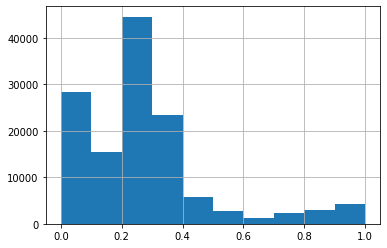

In [ ]:
sent_stat["sent_edit_distance"].hist()

In [ ]:
#To check exactly how many sentences fall into the “bad” and the “good” categories:

In [ ]:
MAXIMUM_AVERAGE_EDIT_DISTANCE_RATE = 0.4
total_sent = sent_stat.shape[0]
good_sent = (sent_stat["sent_edit_distance"] <= MAXIMUM_AVERAGE_EDIT_DISTANCE_RATE).sum()
good_sent_ratio = good_sent / total_sent
print("good sentences: %s\ntotal sentences: %s\ngood sentences ratio: %s" % (good_sent, total_sent, good_sent_ratio))

good sentences: 112334
total sentences: 130871
good sentences ratio: 0.8583567024016016


In [ ]:
#Example of Good Sentences

In [ ]:
good_sentences_stat = sent_stat[sent_stat["sent_edit_distance"] <= MAXIMUM_AVERAGE_EDIT_DISTANCE_RATE]
i = random.randint(0, good_sentences_stat.shape[0] - 1)

good_sentences_stat[i: i + 20].sort_values("sent_edit_distance", ascending=False)

,ocr_sentence,gs_sentence,sent_edit_distance
80639,"[— Sd, bätte, ni@ht, bavonlaufen jetn, ©'@]tÖt...","[@Jch, hätte, nicht, davonlaufen@ſein, G'ſicht...",0.370968
80644,"[Dtuf, i@@, im, Otamen, beiner, @@©dönen, bitt...","[@Muß, ich, im, @Namen, deiner, Schoͤnen, bitt...",0.361111
80635,"[@@@@, Beängfjtigung;, er, je@pte, ji@Q, aufre...","[ 80, Beäng@ſtigung;, er, ſetzte, ſich, aufre...",0.343137
80643,"[Da, ffinat, ihr, Zenfterlein, Gprad}, i@h:, t...","[Da, klingt, ihr, Fenſterlein,@Sprach, ich:, M...",0.329268
80634,"[Se@bt, aber, madht, bie, SQuft, mir mi@d, jo,...","[Jetzt, aber, macht, die, @Luft, mir@mich, ſo,...",0.306931
80650,"[GEinfam, auf, dem, @@bödften, SBerg, Da, @ihw...","[@Einſam, auf, dem, hoͤchſten, @Berg,@Da, ſchw...",0.306667
80633,"[@,, bdie, theure,, bie als, bieje, Bafjerftabt?]","[O,, @die, theure,, die@als, dieſe, Waſſerſtadt?]",0.297297
80645,"[©pielt, den, @(h@önften, $o@dpeitreigen!]","[Spielt, den, ſchoͤnſten, Hochzeitreigen!]",0.294118
80646,"[”Devgbruber,, im, Baterlanb!]","[«Herzbruder,, im, Vaterland!]",0.291667
80647,"[Dur@d, dben, Dain Otägblein ,, ftreidh', ibn,...","[Durch, d@en, Hain@Maͤgdlein@,, ſtreich', ihn,...",0.275168


In [ ]:
#to Look noisy sentences

In [ ]:
noisy_sentences_stat = sent_stat[sent_stat["sent_edit_distance"] > MAXIMUM_AVERAGE_EDIT_DISTANCE_RATE]
i = random.randint(0, noisy_sentences_stat.shape[0] - 1)

noisy_sentences_stat[i: i + 20].sort_values("sent_edit_distance", ascending=False)

,ocr_sentence,gs_sentence,sent_edit_distance
21454,[13.],[@Re],1.000000
21458,[Saav.],[El se],1.000000
21462,"[AMIGABLEMENTE,, adv.]","[@@@@@@@@@@@que, @los]",1.000000
21460,[44.],"[na,]",1.000000
21474,[68.],[@@@],1.000000
21463,[de modo.],[@niervos],0.875000
21469,[A@tmice.],[AMIESGAD],0.875000
21466,[afecto.],[óric@as],0.857143
21461,"[En, el qual término, sino fe, componían las d...","[@y, el@@@@l@@@@@@@a, s@@@@@e, @@@@@@@a@@@rrep...",0.818182
21464,[Cariñofa- .],[@a@@@@f@@fó],0.818182


In [ ]:
#Saving the result with pickle format

In [ ]:
words = np.array(words, dtype=object)[good_sentences_stat.index.tolist()].tolist()
labels = np.array(labels, dtype=object)[good_sentences_stat.index.tolist()].tolist()
pickle.dump(words, open("train_ed_filtered_words.pickle", "wb"))
pickle.dump(labels, open("train_ed_filtered_labels.pickle", "wb"))

In [ ]:
##same procedure applies for the test dataset

In [ ]:
test_files = glob.glob(path.join(r"/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/evaluation_4M_without_Finnish/*", "*", "*.txt"))
test_aligned_words, test_words, test_aligned_gs_words, test_labels = extract_dataset(test_files, True)

/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/evaluation_4M_without_Finnish/SL/SL1/18.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/evaluation_4M_without_Finnish/SL/SL1/36.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/evaluation_4M_without_Finnish/SL/SL1/15.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/evaluation_4M_without_Finnish/SL/SL1/37.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/evaluation_4M_without_Finnish/SL/SL1/17.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/evaluation_4M_without_Finnish/SL/SL1/25.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/evaluation_4M_without_Finnish/SL/SL1/38.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/evaluation_4M_without_Finnish/SL/SL1/14.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/evaluation_4M_without_Finnish/SL/SL1/26.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth/evaluation_4M_without_Finnish/SL/SL1/33.txt
/content/drive/MyDrive/ICDAR2019-POCR-ground-truth

In [ ]:
test_sent_stat = pd.DataFrame({"ocr_sentence": test_aligned_words, "gs_sentence": test_aligned_gs_words})
test_sent_stat["sent_edit_distance"] = test_sent_stat.apply(compute_sent_edit_distance, axis=1)

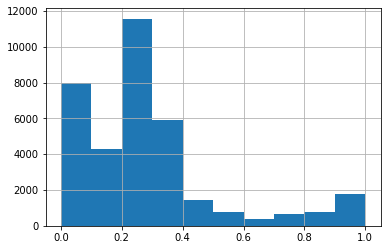

In [ ]:
test_sent_stat["sent_edit_distance"].hist()


In [ ]:
#To check exactly how many sentences fall into the “bad” and the “good” categories:

In [ ]:
print("good sentences: %s\ntotal sentences: %s\ngood sentences ratio: %s" % ((test_sent_stat["sent_edit_distance"] <= MAXIMUM_AVERAGE_EDIT_DISTANCE_RATE).sum(), test_sent_stat.shape[0], (test_sent_stat["sent_edit_distance"] < MAXIMUM_AVERAGE_EDIT_DISTANCE_RATE).sum() / test_sent_stat.shape[0]))
test_good_sentences_stat = test_sent_stat[test_sent_stat["sent_edit_distance"] <= MAXIMUM_AVERAGE_EDIT_DISTANCE_RATE]

good sentences: 29934
total sentences: 35589
good sentences ratio: 0.8358481553288938


In [ ]:
#Saving the result with pickle format

In [ ]:
eval_words = np.array(test_words, dtype=object)[test_good_sentences_stat.index.tolist()].tolist()
eval_labels = np.array(test_labels, dtype=object)[test_good_sentences_stat.index.tolist()].tolist()
pickle.dump(eval_words, open("test_ed_filtered_words.pickle", "wb"))
pickle.dump(eval_labels, open("test_ed_filtered_labels.pickle", "wb"))

In [ ]:
#Training the model

In [ ]:
#First load the multiligual training and test dataset:

In [ ]:
eval_words = pickle.load(open("test_ed_filtered_words.pickle", "rb"))
eval_labels = pickle.load(open("test_ed_filtered_labels.pickle", "rb"))
words = pickle.load(open("train_ed_filtered_words.pickle", "rb"))
labels = pickle.load(open("train_ed_filtered_labels.pickle", "rb"))

In [ ]:
#Lets check how many typos are there in the training dataset : 

In [ ]:
pos_labels_count = sum(sum(sent_labels) for sent_labels in labels)
total_labels_count = sum(len(sent_labels) for sent_labels in labels)
print(f"typo words: {pos_labels_count}, total: {total_labels_count}, typo_rate: {pos_labels_count / total_labels_count}")


typo words: 1317455, total: 2468919, typo_rate: 0.5336161291642213


In [ ]:
#Now let us Prepare input for the models

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")


Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
# We tokenize each word into BERT subtokens and assign each of them a label from the entire word using the following function:

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    """ Tokenize sentence into BERT subtokens."""
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

#     Adding CLS and SEP tokens
    tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"]
    labels = [0] + labels + [0]
    return tokenized_sentence, labels

In [ ]:
#The length of sequences must be adjusted in order to transform the data into tensor format. The following function can be used to accomplish result


def truncate_or_pad(arr, max_sequence_length):
    """ Truncate or pad the `arr` according the maximum sequence length"""
    
    return arr[:max_sequence_length] + [tokenizer.pad_token_id] * (max_sequence_length - len(arr))


In [ ]:
#The following procedures are used to prepare sufficient input data for the model:


#1.Using BERT's Word piece tokenization, tokenize the words.
#2.Generating ids from tokens
#3.Aligning sequence lengths to the maximum length
#4.Creating attention masks with a padding of 0
#5.Tensorization of token ids, labels, and attention masks


In [ ]:
def prepare_dataset(words, labels, max_sequence_length=100):
    """Extract inputs, tags and masks tensors from the dataset"""

    tokenized_texts_and_labels = [tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(words, labels)]

    tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
    tokenized_labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]
    input_ids = np.array([truncate_or_pad(tokenizer.convert_tokens_to_ids(txt), max_sequence_length) for txt in tokenized_texts], dtype='long')
    subtoken_labels = np.array([truncate_or_pad(sentence_labels, max_sequence_length) for sentence_labels in tokenized_labels], dtype='long')
    attention_masks = [[int(i != 0) for i in ii] for ii in input_ids]

    inputs = torch.tensor(input_ids, dtype=torch.long)
    tags = torch.tensor(subtoken_labels, dtype=torch.long)
    masks = torch.tensor(attention_masks, dtype=torch.long)
    return inputs, tags, masks
MAX_SEQUENCE_LENGTH = 100
tr_inputs, tr_tags, tr_masks = prepare_dataset(words, labels, MAX_SEQUENCE_LENGTH)
val_inputs, val_tags, val_masks = prepare_dataset(eval_words, eval_labels, MAX_SEQUENCE_LENGTH)

In [ ]:
# Pickling the tensors for later reuse is a useful way to save them:

In [ ]:
prepared_data_dir = "prepared_data"
os.makedirs(prepared_data_dir, exist_ok=True)

# Storing the pickled data and the tokenizer instance. Can be commented out later

pickle.dump(tr_inputs, open(path.join(prepared_data_dir, "tr_inputs.pickle"), "wb"))
pickle.dump(val_inputs, open(path.join(prepared_data_dir, "val_inputs.pickle"), "wb"))
pickle.dump(tr_tags, open(path.join(prepared_data_dir, "tr_tags.pickle"), "wb"))
pickle.dump(val_tags, open(path.join(prepared_data_dir, "val_tags.pickle"), "wb"))
pickle.dump(tr_masks, open(path.join(prepared_data_dir, "tr_masks.pickle"), "wb"))
pickle.dump(val_masks, open(path.join(prepared_data_dir, "val_masks.pickle"), "wb"))
tokenizer.save_pretrained(prepared_data_dir)

# Loading the pickled data and the tokenizer instance

tokenizer = BertTokenizer.from_pretrained(prepared_data_dir)
tr_inputs = pickle.load(open(path.join(prepared_data_dir, "tr_inputs.pickle"), "rb"))
val_inputs = pickle.load(open(path.join(prepared_data_dir, "val_inputs.pickle"), "rb"))
tr_tags = pickle.load(open(path.join(prepared_data_dir, "tr_tags.pickle"), "rb"))
val_tags = pickle.load(open(path.join(prepared_data_dir, "val_tags.pickle"), "rb"))
tr_masks = pickle.load(open(path.join(prepared_data_dir, "tr_masks.pickle"), "rb"))
val_masks = pickle.load(open(path.join(prepared_data_dir, "val_masks.pickle"), "rb"))

In [ ]:
##### MODEL  ##### 

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, hidden_dropout_prob):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.dropout = nn.Dropout(hidden_dropout_prob)
        self.kernel_1 = 2
        self.kernel_2 = 3
        self.kernel_3 = 4
        self.kernel_4 = 5
        self.embedding_dim = 768
        self.out_size = 32
        self.num_labels = 2

        # Different paddings are used in order to preserve the original sequence lengths.
        
        self.conv_1 = nn.Conv1d(self.embedding_dim, self.out_size, self.kernel_1, stride=1, padding=1)
        self.pool_1 = nn.MaxPool1d(kernel_size=self.kernel_1, stride=1)
        self.conv_2 = nn.Conv1d(self.embedding_dim, self.out_size, self.kernel_2, stride=1, padding=1)
        self.pool_2 = nn.MaxPool1d(kernel_size=self.kernel_2, stride=1, padding=1)
        self.conv_3 = nn.Conv1d(self.embedding_dim, self.out_size, self.kernel_3, stride=1, padding=2)
        self.pool_3 = nn.MaxPool1d(kernel_size=self.kernel_3, stride=1, padding=1)
        self.conv_4 = nn.Conv1d(self.embedding_dim, self.out_size, self.kernel_4, stride=1, padding=2)
        self.pool_4 = nn.MaxPool1d(kernel_size=self.kernel_4, stride=1, padding=2)
        self.classifier = nn.Linear(self.out_size * 4, self.num_labels)
    
    def forward(self, input, attention_mask):
        outputs = self.bert(input, attention_mask)
        sequence_output = outputs[0] # batch_size, sequence_length, hidden_size
        conv_input = sequence_output.permute(0, 2, 1) # batch_size, hidden_size, sequence_length
        conv_output_1 = self.conv_1(conv_input)
        conv_output_1 = torch.relu(conv_output_1)
        pool_output_1 = self.pool_1(conv_output_1)
        conv_output_2 = self.conv_2(conv_input)
        conv_output_2 = torch.relu(conv_output_2)
        pool_output_2 = self.pool_2(conv_output_2)
        conv_output_3 = self.conv_3(conv_input)
        conv_output_3 = torch.relu(conv_output_3)
        pool_output_3 = self.pool_3(conv_output_3)
        conv_output_4 = self.conv_4(conv_input)
        conv_output_4 = torch.relu(conv_output_4)
        pool_output_4 = self.pool_4(conv_output_4)
        conc_pool_output = torch.cat((pool_output_1, pool_output_2, pool_output_3, pool_output_4), 1)  # batch_size, out_size * 4, sequence_length
        conc_pool_output = conc_pool_output.permute(0, 2, 1)  # batch_size, sequence_length, out_size * 4
        sequence_output = self.dropout(conc_pool_output)
        logits = self.classifier(sequence_output)  # batch_size, sequence_length, 2
        return logits

In [ ]:
# Acivating GPU if Avilable or else working with CPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Now preparing the data loader for trainig and validation  

In [ ]:
BATCH_SIZE = 32
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, pin_memory=True, num_workers=2, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [ ]:
#Setting up the model and transmitting it to the appropriate device:

In [ ]:
model = CNNModel(0.1)
model.to(device)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CNNModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [ ]:
#using Adam Optimizer for non bias parameters with weight of 0.01

In [ ]:
param_optimizer = list(model.named_parameters())
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if "bias" in n],
        'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if "bias" not in n],
        'weight_decay_rate': 0.0}
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# The BERT authors also suggest using 4 epochs or less for linear attenuation of training and  learning rates. 
#In this case, the model always overrides the third epoch. 
#In addition, use clipping  to prevent the gradient from exploding.

In [ ]:
epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
## Store the average loss and accuracy after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
training_acc, val_acc = [], []
best_valid_loss = float('inf')
best_valid_acc = 0

best_acc_output_dir = "cnnmodel_best_acc_all"
best_loss_output_dir = "cnnmodel_best_loss_all"

# Create output directory if needed
os.makedirs(best_acc_output_dir, exist_ok=True)
os.makedirs(best_loss_output_dir, exist_ok=True)

print("Best validation accuracy model location: %s" % best_acc_output_dir)
print("Best validation loss model location: %s" % best_loss_output_dir)
all_predictions = []
all_true_labels = []
all_masks = []

for epoch in range(epochs):
    print(f"Epoch:{epoch}")
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    true_labels = []
    logits_list = []
    label_ids_list = []
    for step, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
    # for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        logits = model(b_input_ids, attention_mask=b_input_mask)
        loss_fct = nn.CrossEntropyLoss()
        # Only keep active parts of the loss
        active_loss = b_input_mask.view(-1) == 1
        active_logits = logits.view(-1, model.num_labels)
        active_labels = torch.where(
            active_loss, b_labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(b_labels)
        )
        loss = loss_fct(active_logits, active_labels)
        
        logits = logits.detach()
        logits_list.append(logits)
        true_labels.extend(b_labels)

        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    
    predictions = [list(p) for logits in logits_list for p in np.argmax(logits.to("cpu").numpy(), axis=2)]
    true_labels = [tl.to("cpu").numpy() for tl in true_labels]
    
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("\nTraining loss: {}".format(avg_train_loss))
                                  
    b_input_mask_list = b_input_mask.cpu().numpy().tolist()
    pred_tags = [p_i for p, l, a in zip(predictions, true_labels, b_input_mask_list)
                                 for p_i, l_i, a_i in zip(p, l, a) if a_i]
    valid_tags = [l_i for l, a in zip(true_labels, b_input_mask_list)
                                  for l_i, a_i in zip(l, a) if a_i]

    acc = accuracy_score(pred_tags, valid_tags)
    print("Training Accuracy: {}".format(acc))
    training_acc.append(acc)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions, true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            logits = model(b_input_ids, b_input_mask)
        # Move logits and labels to CPU
        label_ids = b_labels.to('cpu').numpy()

        loss_fct = nn.CrossEntropyLoss()
        # Only keep active parts of the loss
        active_loss = b_input_mask.view(-1) == 1
        active_logits = logits.view(-1, model.num_labels)
        active_labels = torch.where(
            active_loss, b_labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(b_labels)
        )
        loss = loss_fct(active_logits, active_labels).item()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += loss
        logits = logits.detach().cpu().numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    b_input_mask_list = b_input_mask.cpu().numpy().tolist()
    pred_tags = [p_i for p, l, a in zip(predictions, true_labels, b_input_mask_list)
                                 for p_i, l_i, a_i in zip(p, l, a) if a_i]
    valid_tags = [l_i for l, a in zip(true_labels, b_input_mask_list)
                                  for l_i, a_i in zip(l, a) if a_i]
    acc = accuracy_score(pred_tags, valid_tags)
    all_predictions.append(predictions)
    all_true_labels.append(true_labels)
    all_masks.append(b_input_mask_list)
    
    print("Validation Accuracy: {}".format(acc))
    val_acc.append(acc)
    
    
    if eval_loss < best_valid_loss:
        best_valid_loss = eval_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path.join(best_loss_output_dir, "model"))
        tokenizer.save_pretrained(best_loss_output_dir)
    
    if acc > best_valid_acc:
        best_valid_acc = acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path.join(best_acc_output_dir, "model"))
        tokenizer.save_pretrained(best_acc_output_dir)


Best validation accuracy model location: cnnmodel_best_acc_all
Best validation loss model location: cnnmodel_best_loss_all
Epoch:0


100%|██████████| 3511/3511 [33:07<00:00,  1.77it/s]



Training loss: 0.18803669742516255
Training Accuracy: 0.5866477272727273
Validation loss: 0.1795226542247284
Validation Accuracy: 0.9476309226932669
Epoch:1


100%|██████████| 3511/3511 [33:16<00:00,  1.76it/s]



Training loss: 0.13869878842289277
Training Accuracy: 0.9659863945578231
Validation loss: 0.1738816800638715
Validation Accuracy: 0.9376558603491272
Epoch:2


100%|██████████| 3511/3511 [33:15<00:00,  1.76it/s]



Training loss: 0.11316087898859031
Training Accuracy: 0.9564606741573034
Validation loss: 0.18132904435818395
Validation Accuracy: 0.942643391521197


In [ ]:
## Plot them with training loss and validation loss

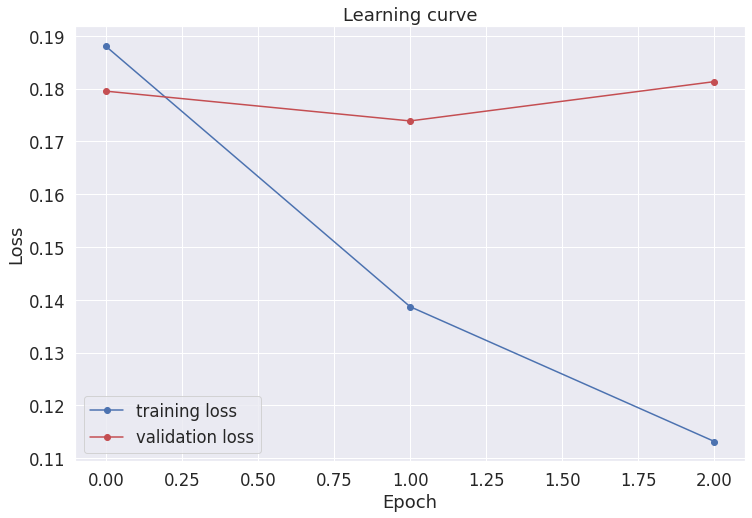

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,8)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

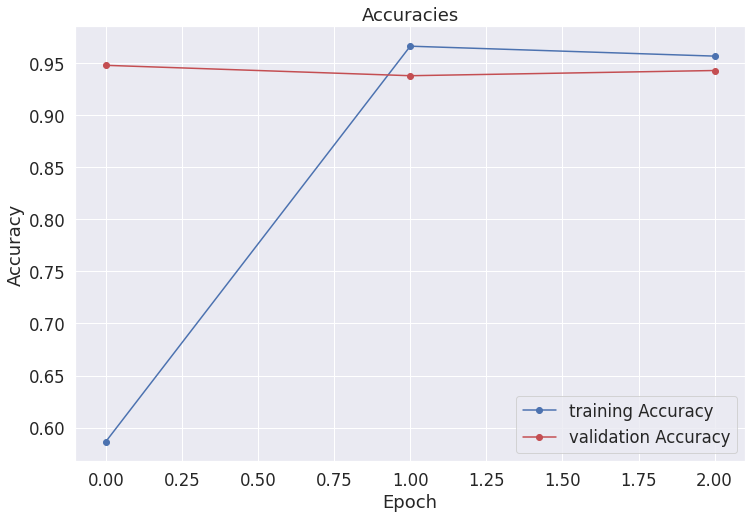

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,8)

# Plot the Accuracies.
plt.plot(training_acc, 'b-o', label="training Accuracy")
plt.plot(val_acc, 'r-o', label="validation Accuracy")

# Label the plot.
plt.title("Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [ ]:
# Inference

# Now lets check at the end how good our model is

#Lets first load the model with best validation loss and also saved the tokenizer : 

In [ ]:
output_dir = "cnnmodel_best_loss_all"
tokenizer1 = BertTokenizer.from_pretrained(output_dir)

model1 = CNNModel(0.1)
checkpoint = torch.load(path.join(output_dir, "model"))
model1.load_state_dict(checkpoint['model_state_dict'])
# Copy the model to the GPU.
model1.to(device)
model1.eval()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CNNModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [ ]:
# Now check the following sentence:

In [ ]:
test_sentence = """
Eroxena, Does my soul make an impreillon upon my ryes ?
"""

In [ ]:
# Perform a very similar operation to get the input tensor. Then  run the model and extract the labels from the logit. Finally,  glue the tokenized BERT subtoken and see the result. 
 
# The left column is the typo prediction and  the right is the word itself.

In [ ]:
def inference(test_sentence):
    tokenized_sentence = tokenizer1.encode(test_sentence)
    attention_mask = np.zeros(100)
    attention_mask[:len(tokenized_sentence)] = 1
    tokenized_sentence += [0] * (100 - len(tokenized_sentence))
    input_ids = torch.tensor([tokenized_sentence]).cuda()
    attention_mask = torch.tensor([attention_mask]).cuda()

    with torch.no_grad():
        logits = model1(input_ids, attention_mask)
    label_indices = np.argmax(logits.to('cpu').numpy(), axis=2)

    # join bpe split tokens
    tokens = tokenizer1.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
            if not new_labels[-1] and label_idx:
                new_labels[-1] = label_idx
        else:
            new_labels.append(label_idx)
            new_tokens.append(token)

    for token, label in zip(new_tokens, new_labels):
        if token == "[PAD]":
            break
        print("{}\t{}".format(label, token))

inference(test_sentence)

0	[CLS]
1	Eroxena
1	,
0	Does
0	my
0	soul
0	make
0	an
1	impreillon
0	upon
0	my
0	ryes
0	?
0	[SEP]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  import sys


# So finally the model has captured the idea of typo mistakes and it showed wrong words such as imprelion and **ryes**
